In [ ]:
!pip install librosa soundfile pydub audiomentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.4/109.4 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 20.8 MB/s eta 0:00:00
  Attempting uninstall: soxr
    Found existing installation: soxr 1.0.0
    Uninstalling soxr-1.0.0:
      Successfully uninstalled soxr-1.0.0


In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, RoomSimulator
from google.colab import files


In [ ]:
# Upload your single real T3 audio file
uploaded = files.upload()

# Get filename
t3_file = list(uploaded.keys())[0]
print("Uploaded:", t3_file)


Saving t3_original.wav to t3_original.wav
Uploaded: t3_original.wav


In [ ]:
os.makedirs("dataset/T3", exist_ok=True)
os.makedirs("dataset/Not_T3", exist_ok=True)


In [ ]:
!pip install pyroomacoustics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.1/35.1 MB 69.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.1-py3-none-any.whl.metadata (10.0 kB)
Using cached pybind11-3.0.1-py3-none-any.whl (293 kB)
  Created wheel for pyroomacoustics: filename=pyroomacoustics-0.8.6-cp312-cp312-linux_x86_64.whl size=46999683 sha256=79ba61b6b23d6cfe41c536b1cf811be049ef1795f00199e77072b8274a8785a9
  Stored in directory: /root/.cache/pip/wheels/41/d8/86/0969204fd58c781705094db3a180e34219d82a52d5c0f5e6ac
Successfully built pyroomacoustics


In [ ]:
import librosa
import soundfile as sf
import os
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain, RoomSimulator

# Path to your real T3 audio file
t3_file = "t3_original.wav"

# Load original T3 audio
y, sr = librosa.load(t3_file, sr=16000)

# Define augmentations (fixed for older audiomentations API)
augment = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    Shift(p=0.5),  # ✅ works across all versions
    Gain(min_gain_db=-6, max_gain_db=6, p=0.5),  # ✅ fixed
    RoomSimulator(p=0.3)
])

# Create output directory
os.makedirs("dataset/T3", exist_ok=True)

# Generate augmented versions
for i in range(1000):
    y_aug = augment(samples=y, sample_rate=sr)
    out_file = f"dataset/T3/t3_{i:04d}.wav"
    sf.write(out_file, y_aug, sr)

print("Generated 1000 T3 samples ✅")


/tmp/ipython-input-1636288443.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(t3_file, sr=16000)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Generated 1000 T3 samples ✅


In [ ]:
!wget -q https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
!tar -xzf UrbanSound8K.tar.gz


In [ ]:
import glob, shutil, random

urb_files = glob.glob("UrbanSound8K/audio/fold*/**/*.wav", recursive=True)
selected = random.sample(urb_files, 1000)

for i, f in enumerate(selected):
    shutil.copy(f, f"dataset/Not_T3/neg_{i:04d}.wav")

print("Saved 1000 Not_T3 samples ✅")


Saved 1000 Not_T3 samples ✅


In [ ]:
print("T3 samples:", len(os.listdir("dataset/T3")))
print("Not_T3 samples:", len(os.listdir("dataset/Not_T3")))


T3 samples: 1000
Not_T3 samples: 1000


In [ ]:
!pip install librosa tensorflow


In [ ]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# ---------------------------
# Parameters
# ---------------------------
DATASET_PATH = "dataset"   # dataset folder with T3 and Not_T3
SR = 16000                 # sample rate
DURATION = 3               # seconds (fixed length per sample)
SAMPLES = SR * DURATION
N_MELS = 64


In [ ]:
def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=SR)

    # Pad or trim to 3 sec
    if len(y) > SAMPLES:
        y = y[:SAMPLES]
    else:
        y = np.pad(y, (0, max(0, SAMPLES - len(y))))

    # Mel spectrogram
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=N_MELS)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    # Normalize [0, 1]
    mel_db = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-6)

    return mel_db


In [ ]:
X = []
y = []

for label in ["T3", "Not_T3"]:
    folder = os.path.join(DATASET_PATH, label)
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            path = os.path.join(folder, file)
            mel = preprocess_audio(path)
            X.append(mel)
            y.append(label)

X = np.array(X)
y = np.array(y)

# Add channel dimension (for CNN)
X = X[..., np.newaxis]

print("Dataset shape:", X.shape, y.shape)


Dataset shape: (2000, 64, 94, 1) (2000,)


In [ ]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Train/Val split (80/20)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, stratify=y_cat, random_state=42
)

print("Train:", X_train.shape, "Val:", X_val.shape)


Train: (1600, 64, 94, 1) Val: (400, 64, 94, 1)


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(N_MELS, X.shape[2], 1)),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(2, activation="softmax")
])

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 92, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,058 (394.76 KB)

 Trainable params: 101,058 (394.76 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)


Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - accuracy: 0.6073 - loss: 0.6384 - val_accuracy: 0.7950 - val_loss: 0.4610
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8449 - loss: 0.3698 - val_accuracy: 0.8325 - val_loss: 0.3938
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8665 - loss: 0.3226 - val_accuracy: 0.9100 - val_loss: 0.2577
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9148 - loss: 0.2186 - val_accuracy: 0.9250 - val_loss: 0.2250
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9444 - loss: 0.1902 - val_accuracy: 0.9375 - val_loss: 0.1957
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9637 - loss: 0.1296 - val_accuracy: 0.9600 - val_loss: 0.1302
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9740 - loss: 0.0963 - val_accuracy: 0.9750 - val_loss: 0.1142
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9794 - loss: 0.0967 - val_accuracy: 0.9650 - val_loss

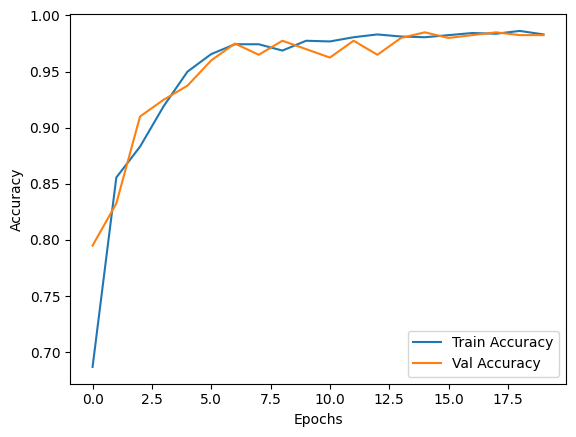

In [ ]:
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
model.save("t3_detector_cnn.h5")
print("✅ Model saved as t3_detector_cnn.h5")


✅ Model saved as t3_detector_cnn.h5


In [ ]:
def predict_audio(file_path, model, encoder):
    mel = preprocess_audio(file_path)
    mel = mel[np.newaxis, ..., np.newaxis]  # add batch + channel dims

    pred = model.predict(mel)
    class_idx = np.argmax(pred)
    class_label = encoder.inverse_transform([class_idx])[0]

    return class_label, pred[0]

# Example: test a file
# test_file = "/content/dataset/T3/t3_0001.wav"   # change to your file path
test_file = "/content/t3_original.wav"
label, confidence = predict_audio(test_file, model, encoder)

print("Prediction:", label)
print("Confidence:", confidence)


/tmp/ipython-input-1166736359.py:2: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SR)
/usr/local/lib/python3.12/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
Prediction: T3
Confidence: [5.5633544e-04 9.9944371e-01]


In [ ]:
model = tf.keras.models.load_model("/content/t3_detector_cnn.h5")
print(model.input_shape)


(None, 64, 94, 1)


In [ ]:
import tensorflow as tf

# Load your model
model = tf.keras.models.load_model("/content/t3_detector_cnn.h5")

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # optional: quantize
tflite_model = converter.convert()

# Save
with open("t3_detector_cnn.tflite", "wb") as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmp884w3ps4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 94, 1), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  137543648835344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510299024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510296528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510295760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510298832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510299984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510299792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510300368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510300752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137543510298256: TensorSpec(shape=(), dtype=tf.resource, name=None)
